In [102]:
import numpy as np
import torch
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [88]:
train_dataset_img = MNIST(root='data/', train=True, download=True)

In [89]:
#Let's check the contents of our directory recursively
!ls -R

data                   mnist-most_basic.ipynb

./data:
MNIST

./data/MNIST:
processed raw

./data/MNIST/processed:
test.pt     training.pt

./data/MNIST/raw:
t10k-images-idx3-ubyte     train-images-idx3-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte     train-labels-idx1-ubyte
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [90]:
test_dataset_img = MNIST(root='data/', train=False)

In [91]:
len(train_dataset_img), len(test_dataset_img)

(60000, 10000)

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

(<matplotlib.image.AxesImage at 0x125d18850>, 9)

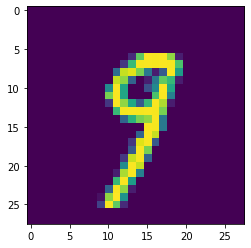

In [93]:
rand_img, label = train_dataset_img[43]
plt.imshow(rand_img), label

In [94]:
train_dataset_tensor = MNIST(root='data/', train=True, transform=transforms.ToTensor())
random_tensor, label = train_dataset_tensor[43]
print (random_tensor.shape, label)

torch.Size([1, 28, 28]) 9


torch.Size([28, 28])


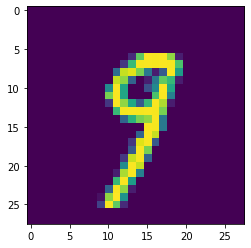

In [95]:
print(random_tensor[0].shape)
plt.imshow(random_tensor[0])

In [96]:
def get_train_val_idxs(dataset, val_percent):
    total_size = len(dataset)
    val_size = int(total_size * val_percent)
    shuffled_idxs = np.random.permutation(total_size)
    return shuffled_idxs[val_size:], shuffled_idxs[:val_size]

train_idxs, val_idxs = get_train_val_idxs(train_dataset_tensor, 0.2)
print(len(train_idxs), len(val_idxs))

48000 12000


In [97]:
BATCH_SIZE = 100
train_loader = DataLoader(dataset=train_dataset_tensor, 
                          batch_size=BATCH_SIZE,
                          sampler=SubsetRandomSampler(train_idxs))
val_loader = DataLoader(dataset=train_dataset_tensor, 
                          batch_size=BATCH_SIZE,
                          sampler=SubsetRandomSampler(val_idxs))

In [131]:
INPUT_SIZE = 28*28
NUM_CLASSES = 10

class CustomMNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_model = nn.Linear(INPUT_SIZE, NUM_CLASSES)
        
    def forward(self, xb):
        #print(f'shape before reshape: {xb.shape}')
        xb = xb.reshape(-1, INPUT_SIZE)
        #print(f'shape after reshape: {xb.shape}')
        out = self.linear_model(xb)
        return out

In [132]:
model = CustomMNISTModel()
print(f'weights shape: {model.linear_model.weight.shape}')
print(f'bias shape: {model.linear_model.bias.shape}')

for images, labels in train_loader:
    outputs = model(images)
    break
print(f'output shape: {outputs.shape}')    

weights shape: torch.Size([10, 784])
bias shape: torch.Size([10])
output shape: torch.Size([100, 10])


In [133]:
probs = F.softmax(outputs, dim=1)
print(f'probabilities of first output: {probs[0]}')
print(f'sum of the above: {torch.sum(probs[0])}')

# Here, I'm expecting to see the max value of the probabilities above
# And the index corresponding to that will give the predicted number
max_vals, max_idxs = torch.max(probs, dim=1)
print(f'max_vals of first output: {max_vals[0]}')
print(f'max_idxs of first output: {max_idxs[0]}')

probabilities of first output: tensor([0.1174, 0.0975, 0.0945, 0.1018, 0.0932, 0.0976, 0.0985, 0.0953, 0.1067,
        0.0976], grad_fn=<SelectBackward>)
sum of the above: 1.0
max_vals of first output: 0.11735672503709793
max_idxs of first output: 0


In [134]:
def calc_accuracy(preds, labels):
    max_vals, max_idxs = torch.max(preds, dim=1)
    return torch.sum(max_idxs==labels).item() / len(max_idxs)
accuracy = calc_accuracy(outputs, labels)
print(f'non-differentiable basic accuracy: {accuracy}')

loss = F.cross_entropy(outputs, labels)
print(f'differentiable, cross entropy loss: {loss}')

non-differentiable basic accuracy: 0.13
differentiable, cross entropy loss: 2.3553218841552734


In [167]:
def batch_loss_train(model, loss_func, inputs, labels, opt):
    preds = model(inputs)
    loss = loss_func(preds, labels)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

def batch_loss_valid(model, loss_func, inputs, labels, metric_func):
    preds = model(inputs)
    loss = loss_func(preds, labels)
    result_metric = metric_func(preds, labels)
    return loss.item(), len(inputs), result_metric

def eval_for_metric(model, loss_func, valid_loader, metric_func):
    with torch.no_grad():
        val_results = [batch_loss_valid(model, 
                                        loss_func, 
                                        inputs, 
                                        labels, 
                                        metric_func) 
                       for inputs,labels in val_loader]
        losses, lens, results = zip(*val_results)
        total_len = np.sum(lens)
        avg_loss = np.sum(np.multiply(losses, lens)) / total_len
        avg_metric = np.sum(np.multiply(results, lens)) / total_len
    return avg_loss, avg_metric

In [154]:
avg_val_loss, avg_val_acc = eval_for_metric(model,
                                            loss_fn,
                                            val_loader, 
                                            calc_accuracy)
print(f'avg val loss: {avg_val_loss}\navg_val_acc: {avg_val_acc}')

avg val loss: 1.8746709416309992
avg_val_acc: 0.66275


epoch:0/50 - loss:1.8936725348234176 - calc_accuracy:0.6448333333333334
epoch:1/50 - loss:1.5879455526669821 - calc_accuracy:0.7465
epoch:2/50 - loss:1.3736194262901942 - calc_accuracy:0.77625
epoch:3/50 - loss:1.2201799660921098 - calc_accuracy:0.7941666666666667
epoch:4/50 - loss:1.1067562838395437 - calc_accuracy:0.8065833333333333
epoch:5/50 - loss:1.0201753740509352 - calc_accuracy:0.8155
epoch:6/50 - loss:0.9521220778425534 - calc_accuracy:0.8218333333333333
epoch:7/50 - loss:0.8973137433330218 - calc_accuracy:0.8275
epoch:8/50 - loss:0.85218425989151 - calc_accuracy:0.8325833333333333
epoch:9/50 - loss:0.8143189842502276 - calc_accuracy:0.8380833333333333
epoch:10/50 - loss:0.7821044241388638 - calc_accuracy:0.8420833333333333
epoch:11/50 - loss:0.7542943671345711 - calc_accuracy:0.8458333333333333
epoch:12/50 - loss:0.7300466914971669 - calc_accuracy:0.8478333333333333
epoch:13/50 - loss:0.7087292090058327 - calc_accuracy:0.8499166666666667
epoch:14/50 - loss:0.6897371878226598

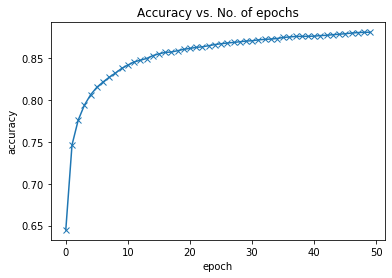

In [171]:
def fit(num_of_epochs, model, loss_func, opt, train_loader, val_loader, val_metric_func):
    val_metrics = []
    for epoch in range(num_of_epochs):
        for inputs, labels in train_loader:
            train_loss = batch_loss_train(model, 
                                          loss_func, 
                                          inputs, 
                                          labels, 
                                          opt)
            
        val_loss, val_metric_result = eval_for_metric(model, 
                                                      loss_func, 
                                                      val_loader, 
                                                      val_metric_func)
        
        print(f'epoch:{epoch}/{num_of_epochs} - loss:{val_loss} - {val_metric_func.__name__}:{val_metric_result}')
        val_metrics.append(val_metric_result)
    return val_metrics

LEARNING_RATE = 0.001
model = CustomMNISTModel()
opt = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_func = F.cross_entropy
accuracies = fit(50, 
                 model, 
                 loss_func, 
                 opt, 
                 train_loader, 
                 val_loader, 
                 calc_accuracy)
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

predicted label: 4


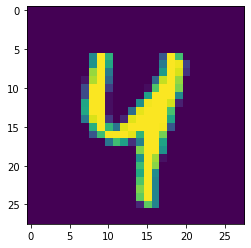

In [172]:
def predict_img_label(img):
    inputs = img.unsqueeze(0)
    predict = model(inputs)
    max_vals, max_idxs = torch.max(predict, dim=1)
    return max_idxs[0]

test_dataset_tensor = MNIST(root='data/', train=False, transform=transforms.ToTensor())
random_img, label = test_dataset_tensor[42]
plt.imshow(random_img[0])

print(f'predicted label: {predict_img_label(random_img)}')

In [173]:
test_loader = DataLoader(test_dataset_tensor, BATCH_SIZE)
test_loss, test_metric_result = eval_for_metric(model, 
                                                loss_func, 
                                                test_loader, 
                                                calc_accuracy)
print(f'test loss: {test_loss} with test accuracy result: {test_metric_result}')

test loss: 0.46705234199762347 with test accuracy result: 0.8813333333333333


In [174]:
model.state_dict()

OrderedDict([('linear_model.weight',
              tensor([[ 0.0186,  0.0168, -0.0294,  ...,  0.0229, -0.0109,  0.0293],
                      [-0.0014,  0.0208, -0.0120,  ..., -0.0203,  0.0028, -0.0355],
                      [-0.0003,  0.0132,  0.0045,  ..., -0.0157,  0.0110,  0.0068],
                      ...,
                      [-0.0075, -0.0281, -0.0063,  ..., -0.0063,  0.0056,  0.0256],
                      [ 0.0110, -0.0251,  0.0084,  ..., -0.0180, -0.0286, -0.0054],
                      [ 0.0021, -0.0325,  0.0083,  ..., -0.0096, -0.0197, -0.0024]])),
             ('linear_model.bias',
              tensor([-0.0582,  0.1526, -0.0477, -0.0329,  0.0604,  0.1375, -0.0320,  0.0628,
                      -0.2190, -0.0320]))])

In [178]:
MODEL_PATH = 'saved-mnist-logisticRegression.pth'
torch.save(model.state_dict(), MODEL_PATH)

#Let's make sure that the reloaded model has the same params
reloaded_model = CustomMNISTModel()
reloaded_model.load_state_dict(torch.load(MODEL_PATH))
reloaded_model.state_dict()

reloaded_test_loss, reloaded_test_metric_result = eval_for_metric(reloaded_model, 
                                                                  loss_func, 
                                                                  test_loader, 
                                                                  calc_accuracy)
print(f'reloaded model test loss: {reloaded_test_loss} with test accuracy result: {reloaded_test_metric_result}')

reloaded model test loss: 0.4670523390173912 with test accuracy result: 0.8813333333333333
